### Data Science Project 

##### Topic - Comparing Data Augmentation methods - Generative Adversarial Networks, Back Translation and Easy Data Augmentation - for intent classification with BERT



In [1]:
# loading the required modules...
import json 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contractions 
import string
import re

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

In [3]:
nltk.download("maxent_ne_chunker")
nltk.download("words")
nltk.download("stopwords")

[nltk_data] Error loading maxent_ne_chunker: <urlopen error [Errno
[nltk_data]     11001] getaddrinfo failed>
[nltk_data] Error loading words: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [4]:
stops = set(stopwords.words("english"))

In [5]:
lemmatizer = WordNetLemmatizer()

In [6]:
# setiing plot style
plt.style.use("seaborn-v0_8-darkgrid")

In [7]:
# data location
data_loc = r"D:\MScDataScience\7.Data_Science_Project\Dataset\clinc150\clinc150_uci\data_small.json"

In [8]:
# loading the data 
with open(data_loc) as data:
    clinc150_small = json.load(data)

In [9]:
# looking all different sets/keys in the data json file
print("The sets in the files are:")
for set in clinc150_small.keys():
    print(set)

The sets in the files are:
oos_val
val
train
oos_test
test
oos_train


train, val and test represents the data within domain, whereas oos_train, oos_val & oos_test contains the out of scoop/domain queries.

In [10]:
# loading training, validation and testing sets from the file..
# training data
train_data = pd.DataFrame(clinc150_small["train"], columns=["Query", "Intent"])
# validation data
val_data = pd.DataFrame(clinc150_small["val"], columns=["Query", "Intent"])
# testing data
test_data = pd.DataFrame(clinc150_small["test"], columns=["Query", "Intent"])

In [11]:
# looking at the taining data
train_data.head()

,Query,Intent
0,can you walk me through setting up direct depo...,direct_deposit
1,i want to switch to direct deposit,direct_deposit
2,set up direct deposit for me,direct_deposit
3,how do i go about setting up direct deposit,direct_deposit
4,i need to get my paycheck direct deposited to ...,direct_deposit


In [12]:
# looking at the testing data
test_data.head()

,Query,Intent
0,how would you say fly in italian,translate
1,what's the spanish word for pasta,translate
2,how would they say butter in zambia,translate
3,how do you say fast in spanish,translate
4,what's the word for trees in norway,translate


In [13]:
# looking at the validation data
val_data.head()

,Query,Intent
0,"in spanish, meet me tomorrow is said how",translate
1,"in french, how do i say, see you later",translate
2,how do you say hello in japanese,translate
3,how do i ask about the weather in chinese,translate
4,"how can i say ""cancel my order"" in french",translate


In [14]:
# looking at the length of training data
print("The length of the training data: ", len(train_data))
# looking at the length of testing data
print("The length of the testing data: ", len(test_data))
# looking at the length of validation data
print("The length of the validation data: ", len(val_data))

The length of the training data:  7500
The length of the testing data:  4500
The length of the validation data:  3000


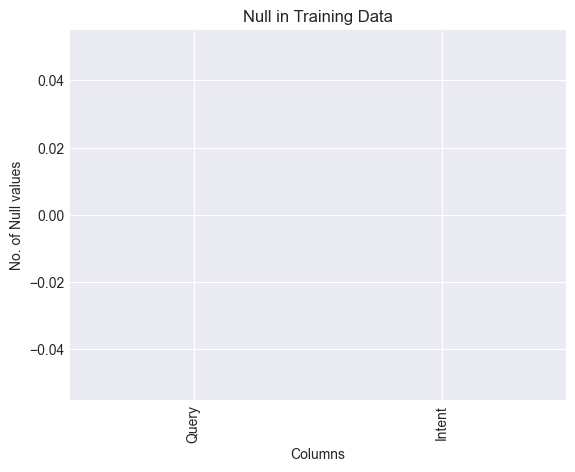

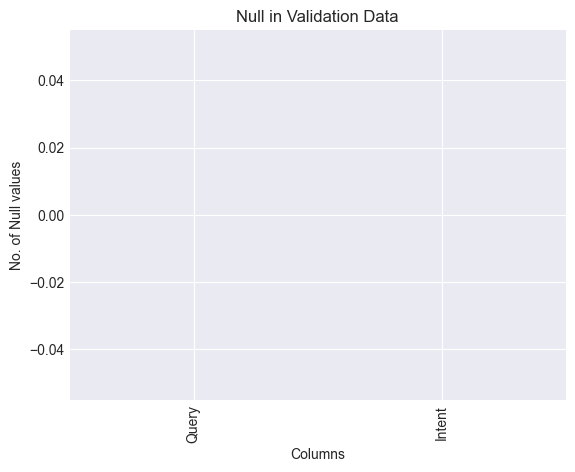

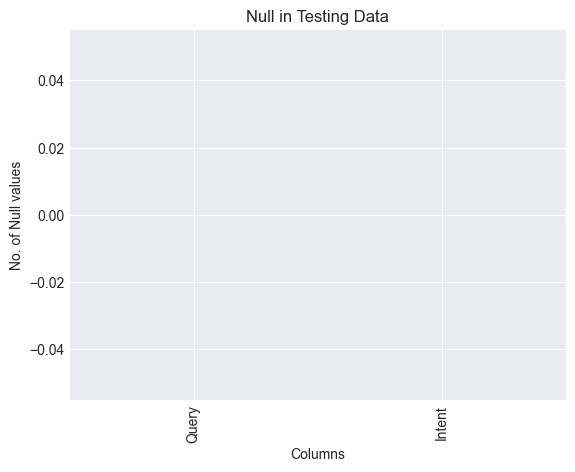

In [15]:
# checking for null values...
# training data...
train_data.isna().sum().plot(kind="bar", 
                             title="Null in Training Data", 
                             xlabel="Columns",
                             ylabel="No. of Null values")
plt.show()
# validation data...
val_data.isna().sum().plot(kind="bar", 
                           title="Null in Validation Data",
                           xlabel="Columns",
                           ylabel="No. of Null values")
plt.show()
# testing data...
test_data.isna().sum().plot(kind="bar",
                             title="Null in Testing Data", 
                             xlabel="Columns",
                             ylabel="No. of Null values")
plt.show()

No null values present in training or validation or testing data.

In [16]:
# Number of queries per intent class...
# training data...
train_per_intent_queries = train_data.groupby(by="Intent").agg({"Query": "count"})
print("Number of queries per intention in Training data:\n", 
      train_per_intent_queries)

# validation data...
val_per_intent_queries = val_data.groupby(by="Intent").agg({"Query": "count"})
print("\n\nNumber of queries per intention in Validation data:\n", 
      val_per_intent_queries)

# testing data...
val_per_intent_queries = val_data.groupby(by="Intent").agg({"Query": "count"})
print("\n\nNumber of queries per intention in Testing data:\n", 
      val_per_intent_queries)

Number of queries per intention in Training data:
                      Query
Intent                    
accept_reservations     50
account_blocked         50
alarm                   50
application_status      50
apr                     50
...                    ...
where_are_you_from      50
whisper_mode            50
who_do_you_work_for     50
who_made_you            50
yes                     50

[150 rows x 1 columns]


Number of queries per intention in Validation data:
                      Query
Intent                    
accept_reservations     20
account_blocked         20
alarm                   20
application_status      20
apr                     20
...                    ...
where_are_you_from      20
whisper_mode            20
who_do_you_work_for     20
who_made_you            20
yes                     20

[150 rows x 1 columns]


Number of queries per intention in Testing data:
                      Query
Intent                    
accept_reservations     20
account_blo

In the training data, there are 50 queries per intention.

In the validation data, there are 20 queries per intention.

In the testing data, there are 20 queries per intention.

Total number of intention are 150

The dataset is balance, meaning the training model will prevent itself from being biased towards one class.

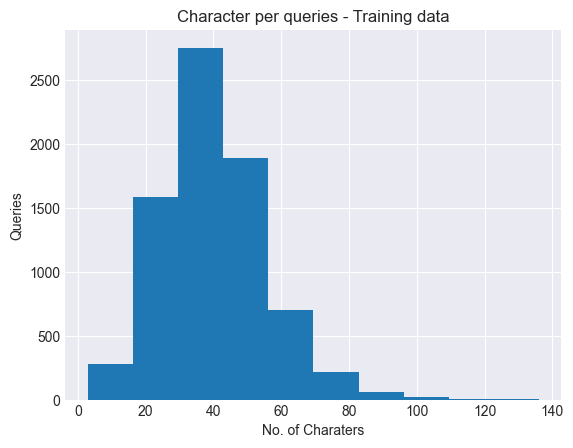

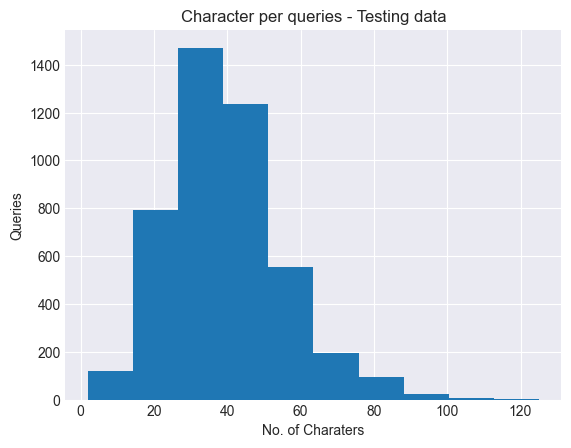

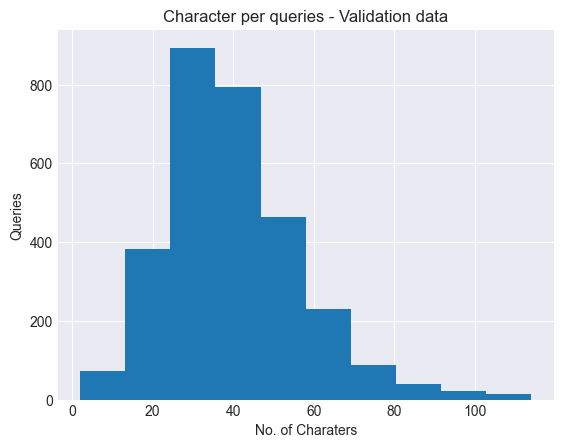

In [17]:
# checking at the number of character per queries...
# training data
train_data["Query"].str.len().plot(kind="hist", 
                                   title="Character per queries - Training data",
                                   ylabel="Queries",
                                   xlabel="No. of Charaters")
plt.show()

# testing data
test_data["Query"].str.len().plot(kind="hist", 
                                   title="Character per queries - Testing data",
                                   ylabel="Queries",
                                   xlabel="No. of Charaters")
plt.show()

# validation data
val_data["Query"].str.len().plot(kind="hist", 
                                   title="Character per queries - Validation data",
                                   ylabel="Queries",
                                   xlabel="No. of Charaters")
plt.show()

For training data, the number of characters range from 4 to 110, and generally between 20 to 65.

For testing data, it ranges from 4 to 100, and generally its about same as training data, 17 to 60.

For validation data, it's same as testing data.

Note: White Space is counted while calculating number of character per queries.

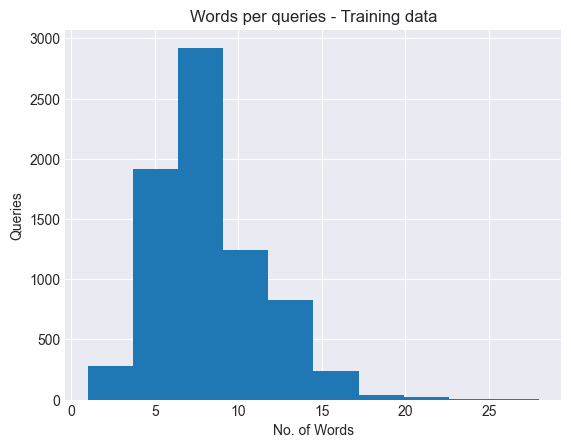

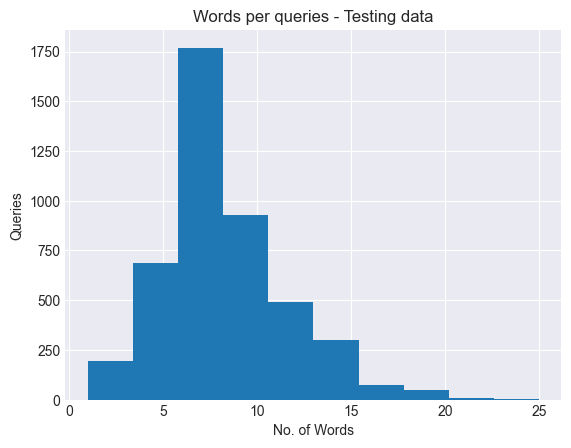

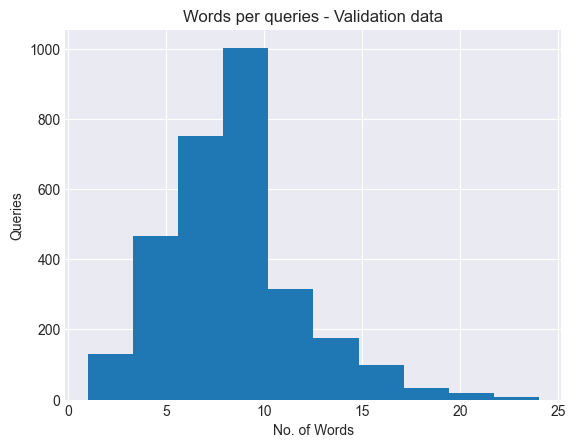

In [18]:
# checking at the number of words per queries...
# training data
train_data["Query"].str.split().str.len().plot(kind="hist", 
                                   title="Words per queries - Training data",
                                   ylabel="Queries",
                                   xlabel="No. of Words")
plt.show()

# testing data
test_data["Query"].str.split().str.len().plot(kind="hist", 
                                   title="Words per queries - Testing data",
                                   ylabel="Queries",
                                   xlabel="No. of Words")
plt.show()

# validation data
val_data["Query"].str.split().str.len().plot(kind="hist", 
                                   title="Words per queries - Validation data",
                                   ylabel="Queries",
                                   xlabel="No. of Words")
plt.show()

The word range in the training, validation and testing data is same, 2 to 20, with most word occuring in range of 5 to 10.

It's seems the queries being asked are short in general. 

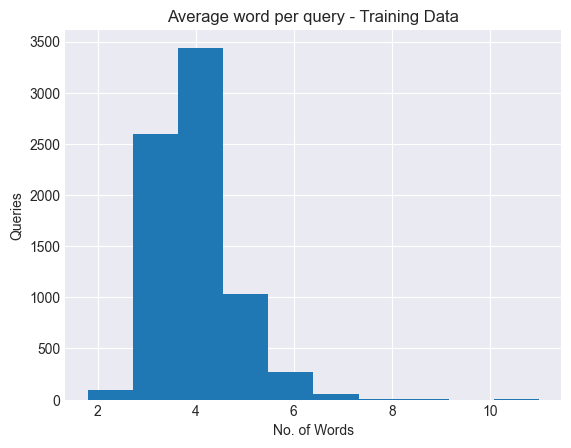

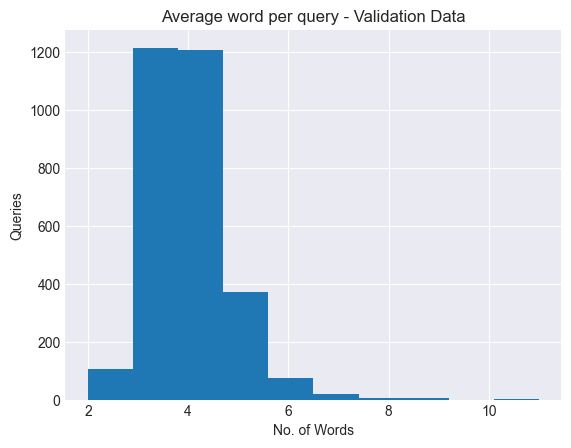

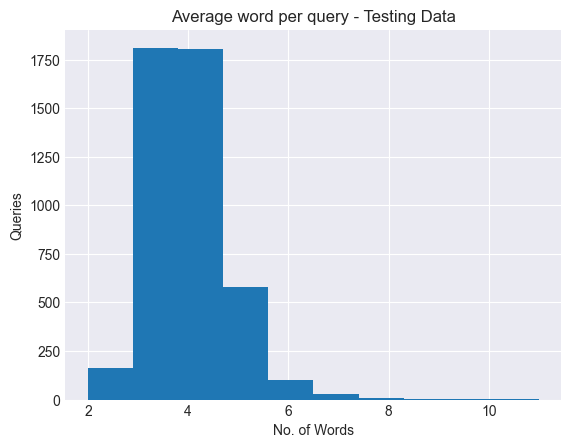

In [19]:
# checking average words per queries...
# training data...
train_data["Query"].str.split().\
    apply(lambda words : [len(word) for word in words]).\
    map(lambda avg_word : np.mean(avg_word)).\
        plot(kind="hist", 
             title="Average word per query - Training Data",
             ylabel="Queries",
             xlabel="No. of Words")
plt.show()

# validation data...
val_data["Query"].str.split().\
    apply(lambda words : [len(word) for word in words]).\
    map(lambda avg_word : np.mean(avg_word)).\
        plot(kind="hist", 
             title="Average word per query - Validation Data",
             ylabel="Queries",
             xlabel="No. of Words")
plt.show()

# testing data...
test_data["Query"].str.split().\
    apply(lambda words : [len(word) for word in words]).\
    map(lambda avg_word : np.mean(avg_word)).\
        plot(kind="hist", 
             title="Average word per query - Testing Data",
             ylabel="Queries",
             xlabel="No. of Words")
plt.show()

The average words per queries is in range of 2 to 6 for all datasets. 

That says the length of the queries being asked are short, commonly.

Pre-processing

In [20]:
# looking at the queries in the data
# needs tabulate package 
# !pip install tabulate
print(train_data["Query"].to_markdown())

|      | Query                                                                                                                                    |
|-----:|:-----------------------------------------------------------------------------------------------------------------------------------------|
|    0 | can you walk me through setting up direct deposits to my bank of internet savings account                                                |
|    1 | i want to switch to direct deposit                                                                                                       |
|    2 | set up direct deposit for me                                                                                                             |
|    3 | how do i go about setting up direct deposit                                                                                              |
|    4 | i need to get my paycheck direct deposited to my chase account                                         

After looking at the queries, it contains the contractions like "I'm", digits like "700", and punctuations like "!".

Expanding the contractions 

In [21]:
# applying contraction fix method to expands the contractions...
# training data
train_data["Processed Query"] = train_data["Query"].\
    apply(lambda query: contractions.fix(query))
# validation data
val_data["Processed Query"] = val_data["Query"].\
    apply(lambda query: contractions.fix(query))
# testing data
test_data["Processed Query"] = test_data["Query"].\
    apply(lambda query: contractions.fix(query))

In [22]:
train_data

,Query,Intent,Processed Query
0,can you walk me through setting up direct depo...,direct_deposit,can you walk me through setting up direct depo...
1,i want to switch to direct deposit,direct_deposit,i want to switch to direct deposit
2,set up direct deposit for me,direct_deposit,set up direct deposit for me
3,how do i go about setting up direct deposit,direct_deposit,how do i go about setting up direct deposit
4,i need to get my paycheck direct deposited to ...,direct_deposit,i need to get my paycheck direct deposited to ...
...,...,...,...
7495,i want my credit limit changed,credit_limit_change,i want my credit limit changed
7496,i would like to increase my bank of america cr...,credit_limit_change,i would like to increase my bank of america cr...
7497,can i increase the credit limit on my old navy...,credit_limit_change,can i increase the credit limit on my old navy...
7498,can i increase the credit limit on my kohls card,credit_limit_change,can i increase the credit limit on my kohls card


In [23]:
# removing digits and words containing digits
# training data...
train_data["Processed Query"] = train_data["Processed Query"].\
    apply(lambda query : re.sub(r"\w*\d\w*", "", query))
# validation data...
val_data["Processed Query"] = val_data["Processed Query"].\
    apply(lambda query : re.sub(r"\w*\d\w*", "", query))
# test data...
test_data["Processed Query"] = test_data["Processed Query"].\
    apply(lambda query : re.sub(r"\w*\d\w*", "", query))

In [24]:
train_data

,Query,Intent,Processed Query
0,can you walk me through setting up direct depo...,direct_deposit,can you walk me through setting up direct depo...
1,i want to switch to direct deposit,direct_deposit,i want to switch to direct deposit
2,set up direct deposit for me,direct_deposit,set up direct deposit for me
3,how do i go about setting up direct deposit,direct_deposit,how do i go about setting up direct deposit
4,i need to get my paycheck direct deposited to ...,direct_deposit,i need to get my paycheck direct deposited to ...
...,...,...,...
7495,i want my credit limit changed,credit_limit_change,i want my credit limit changed
7496,i would like to increase my bank of america cr...,credit_limit_change,i would like to increase my bank of america cr...
7497,can i increase the credit limit on my old navy...,credit_limit_change,can i increase the credit limit on my old navy...
7498,can i increase the credit limit on my kohls card,credit_limit_change,can i increase the credit limit on my kohls card


In [25]:
# removing punctuation from datasets...
# training data
train_data["Processed Query"] = train_data["Processed Query"].\
    apply(lambda query : query.translate(str.maketrans("", "", string.punctuation)))
# validation data
val_data["Processed Query"] = val_data["Processed Query"].\
    apply(lambda query : query.translate(str.maketrans("", "", string.punctuation)))
# testing data
test_data["Processed Query"] = test_data["Processed Query"].\
    apply(lambda query : query.translate(str.maketrans("", "", string.punctuation)))

In [26]:
# tokenizing, removing stopwords and lemmatizing the datasets...
# training data...
train_data["Lemmatized Query"] = train_data["Processed Query"].\
    apply(lambda query : 
          [lemmatizer.lemmatize(word) for word in word_tokenize(query) \
           if word.casefold() not in stops])
# validation data...
val_data["Lemmatized Query"] = val_data["Processed Query"].\
    apply(lambda query : 
          [lemmatizer.lemmatize(word) for word in word_tokenize(query) \
           if word.casefold() not in stops])
# testingg data...
test_data["Lemmatized Query"] = test_data["Processed Query"].\
    apply(lambda query : 
          [lemmatizer.lemmatize(word) for word in word_tokenize(query) \
           if word.casefold() not in stops])

In [27]:
train_data

,Query,Intent,Processed Query,Lemmatized Query
0,can you walk me through setting up direct depo...,direct_deposit,can you walk me through setting up direct depo...,"[walk, setting, direct, deposit, bank, interne..."
1,i want to switch to direct deposit,direct_deposit,i want to switch to direct deposit,"[want, switch, direct, deposit]"
2,set up direct deposit for me,direct_deposit,set up direct deposit for me,"[set, direct, deposit]"
3,how do i go about setting up direct deposit,direct_deposit,how do i go about setting up direct deposit,"[go, setting, direct, deposit]"
4,i need to get my paycheck direct deposited to ...,direct_deposit,i need to get my paycheck direct deposited to ...,"[need, get, paycheck, direct, deposited, chase..."
...,...,...,...,...
7495,i want my credit limit changed,credit_limit_change,i want my credit limit changed,"[want, credit, limit, changed]"
7496,i would like to increase my bank of america cr...,credit_limit_change,i would like to increase my bank of america cr...,"[would, like, increase, bank, america, credit,..."
7497,can i increase the credit limit on my old navy...,credit_limit_change,can i increase the credit limit on my old navy...,"[increase, credit, limit, old, navy, card]"
7498,can i increase the credit limit on my kohls card,credit_limit_change,can i increase the credit limit on my kohls card,"[increase, credit, limit, kohl, card]"


In [28]:
# grouping the data based on intention
lemma_data = train_data[["Lemmatized Query", "Intent"]].groupby(by="Intent").agg({"Lemmatized Query" : "sum"})

In [29]:
lemma_data

,Lemmatized Query
Intent,
accept_reservations,"[take, reservation, arbys, make, reservation, ..."
account_blocked,"[hold, placed, well, fargo, account, hold, cha..."
alarm,"[tomorrow, set, alarm, set, alarm, tomorrow, s..."
application_status,"[application, put, mastercard, go, yet, want, ..."
apr,"[tell, apr, mastercard, current, apr, masterca..."
...,...
where_are_you_from,"[hail, live, baby, last, live, child, live, co..."
whisper_mode,"[volume, whisper, voice, want, whisper, mode, ..."
who_do_you_work_for,"[bos, organization, work, work, wrong, directs..."


In [30]:
lemma_data["Lemmatized Query"].iloc[0]

['take',
 'reservation',
 'arbys',
 'make',
 'reservation',
 'hodaks',
 'take',
 'reservation',
 'state',
 'bird',
 'take',
 'reservation',
 'olive',
 'garden',
 'reservation',
 'taken',
 'redrobin',
 'many',
 'culvers',
 'take',
 'reservation',
 'black',
 'rock',
 'take',
 'reservation',
 'take',
 'reservation',
 'progress',
 'take',
 'reservation',
 'bar',
 'tartine',
 'let',
 'zeus',
 'accepts',
 'reservation',
 'marios',
 'brooklyn',
 'take',
 'reservation',
 'make',
 'reservation',
 'michael',
 'mcdonalds',
 'take',
 'reservation',
 'gramercy',
 'tavern',
 'new',
 'york',
 'accept',
 'reservation',
 'moes',
 'la',
 'except',
 'rerservations',
 'make',
 'reservation',
 'applebees',
 'know',
 'ruth',
 'chris',
 'reservation',
 'minnis',
 'take',
 'reservation',
 'take',
 'reservation',
 'applebees',
 'location',
 'applebees',
 'take',
 'reservation',
 'applebees',
 'take',
 'reservation',
 'tartine',
 'san',
 'francisco',
 'take',
 'reservation',
 'acero',
 'take',
 'reservation',
 

In [31]:
tree = nltk.ne_chunk(nltk.pos_tag(lemma_data["Lemmatized Query"].iloc[0]))
tree.draw()

In [32]:
tree

In [33]:
from nltk import FreqDist

In [34]:
FreqDist(word_tokenize(train_data["Query"][0]))

FreqDist({'can': 1, 'you': 1, 'walk': 1, 'me': 1, 'through': 1, 'setting': 1, 'up': 1, 'direct': 1, 'deposits': 1, 'to': 1, ...})

In [35]:
data = train_data.groupby(by="Intent").agg({"Query" : "sum"})

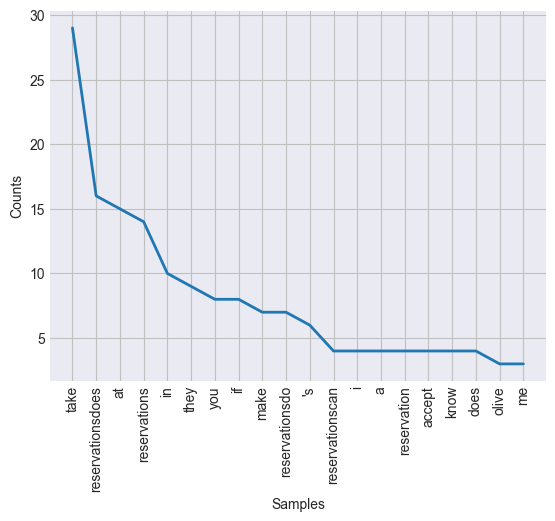

<Axes: xlabel='Samples', ylabel='Counts'>

In [36]:
FreqDist(word_tokenize(data.iloc[0, 0])).plot(20, cumulative=False)

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

In [38]:
cv = CountVectorizer()

In [39]:
pd.DataFrame(cv.fit_transform(train_data[["Intent", 
                                          "Processed Query"]].groupby(by="Intent").\
                                            agg(lambda x:"".join(x))["Processed Query"]).\
                                                toarray(), 
                                                columns=cv.get_feature_names_out(),
                                                index=lemma_data.index)

,aa,aaa,abandon,abc,able,abortplease,about,abouttell,aboutwhat,aboutwhich,...,zippy,zitifor,zone,zonefrench,zonewhat,zonewhich,zoo,zooi,zwhat,zwhen
Intent,,,,,,,,,,,,,,,,,,,,,
accept_reservations,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
account_blocked,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
alarm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
application_status,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
apr,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
where_are_you_from,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
whisper_mode,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
who_do_you_work_for,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
len(cv.get_feature_names_out())

7190

In [41]:
cv.fit_transform(lemma_data["Lemmatized Query"].apply(lambda x:" ".join(x)))

<150x3151 sparse matrix of type '<class 'numpy.int64'>'
	with 9085 stored elements in Compressed Sparse Row format>

In [42]:
dtm = pd.DataFrame(cv.fit_transform(lemma_data["Lemmatized Query"].apply(lambda x:" ".join(x))).\
                                                toarray(), 
                                                columns=cv.get_feature_names_out(),
                                                index=lemma_data.index)

In [43]:
dtm

,aa,aaa,abandon,abc,able,abort,abroad,abrogate,absolutely,ac,...,zander,zealand,zepher,zephers,zesty,zeus,zippy,ziti,zone,zoo
Intent,,,,,,,,,,,,,,,,,,,,,
accept_reservations,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
account_blocked,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
alarm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
application_status,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
apr,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
where_are_you_from,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
whisper_mode,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
who_do_you_work_for,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
freq_data = lemma_data["Lemmatized Query"].apply(lambda x : FreqDist(x))

In [45]:
freq_data

Intent
accept_reservations    {'take': 31, 'reservation': 49, 'arbys': 2, 'm...
account_blocked        {'hold': 18, 'placed': 4, 'well': 2, 'fargo': ...
alarm                  {'tomorrow': 10, 'set': 26, 'alarm': 47, 'want...
application_status     {'application': 41, 'put': 2, 'mastercard': 3,...
apr                    {'tell': 11, 'apr': 50, 'mastercard': 4, 'curr...
                                             ...                        
where_are_you_from     {'hail': 2, 'live': 8, 'baby': 1, 'last': 1, '...
whisper_mode           {'volume': 4, 'whisper': 39, 'voice': 10, 'wan...
who_do_you_work_for    {'bos': 9, 'organization': 2, 'work': 16, 'wro...
who_made_you           {'tell': 5, 'company': 12, 'produce': 1, 'simi...
yes                    {'indeed': 1, 'yes': 12, 'right': 6, 'statemen...
Name: Lemmatized Query, Length: 150, dtype: object

In [46]:
# freq_data.apply(lambda x : x.plot(20))

In [47]:
" ".join(lemma_data["Lemmatized Query"].iloc[0])

'take reservation arbys make reservation hodaks take reservation state bird take reservation olive garden reservation taken redrobin many culvers take reservation black rock take reservation take reservation progress take reservation bar tartine let zeus accepts reservation marios brooklyn take reservation make reservation michael mcdonalds take reservation gramercy tavern new york accept reservation moes la except rerservations make reservation applebees know ruth chris reservation minnis take reservation take reservation applebees location applebees take reservation applebees take reservation tartine san francisco take reservation acero take reservation bar tartine san francisco take reservation buffalo wild wing take reservation michael accept reservation know cheese cake factory reservation cielo take reservation take reservation bjs make reservation chevys make reservation redrobin please find napoli take lunch reservation accept reservation michael arbys lakewood take reservation

In [48]:
from wordcloud import WordCloud
from textwrap import wrap

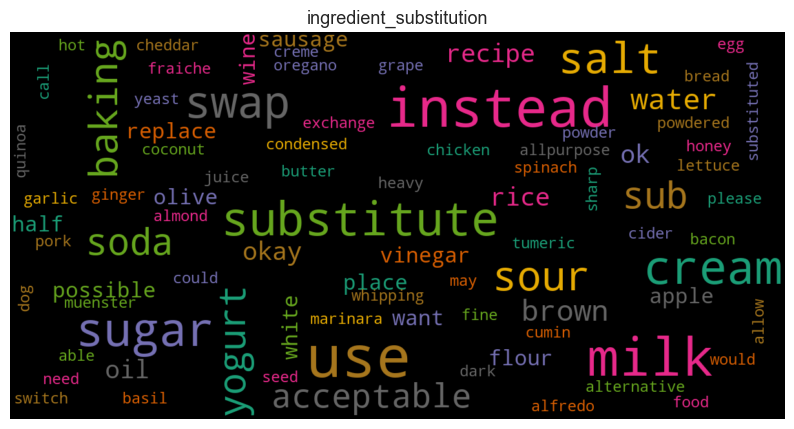

In [49]:
wordcloud = WordCloud(
        max_words=200,
        max_font_size=30,
        scale=3,
        random_state=1, 
        colormap="Dark2").generate_from_frequencies(dtm.iloc[55, :])
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('\n'.join(wrap(dtm.index[55],80)),fontsize=13)
plt.show()